### Idee

**Questa sezione viene utilizzata per scrivere tutto ciò che ci viene in mente da poter implementare per rendere il progetto più interessante**

- Usare le colonne di ground truth (drink e smoke) come features vere e proprie per la classificazione di smoke e drink
- Provare a fare classificazione senza includere le colonne di ground truth (drink e smoke) come features
- Fare un modello che predica se il paziente mente oppure no (probabilmente si farà clustering)
- Utilizzare Adaboost come predittore: esiste già una libreria, ha senso mettere quello che abbiamo scritto in Data Mining?

### Analisi e studio delle distribuzioni dei dati

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

/Users/marcodeano/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("sooyoungher/smoking-drinking-dataset")
print("Path to dataset files:", path)

file_name = "smoking_driking_dataset_Ver01.csv"
file_path = f"{path}/{file_name}"
dataset = pd.read_csv(file_path)

Path to dataset files: /Users/marcodeano/.cache/kagglehub/datasets/sooyoungher/smoking-drinking-dataset/versions/2


In [ ]:
# Analisi iniziale del dataset
print("\nPrime righe del dataset:")
print(dataset.head())

print("\nDimensioni del dataset:")
print(dataset.shape)

print("\nTipi di dati:")
print(dataset.info())

print("\nStatistiche descrittive di base:")
print(dataset.describe())


Prime righe del dataset:
    sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0  Male   35     170      75       90.0         1.0          1.0        1.0   
1  Male   30     180      80       89.0         0.9          1.2        1.0   
2  Male   40     165      75       91.0         1.2          1.5        1.0   
3  Male   50     175      80       91.0         1.5          1.2        1.0   
4  Male   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1.0  138.0  ...      117.0         104.0        13.8            1.0   

   serum_cre

__Prime considerazioni__: I dati sembrano non contenere dati nulli o NaN, però si osserva facilmente che per alcune feature ci sono dei dati che sembrano essere irrealistici (Es.: per la feature **waistline** la media risulta essere _81_, il 4° quartile _87_ e il valore massimo _999_); quindi nonostante la non presenza di valori nulli, bisogna verificare se sono presenti valori mancanti codificati in altro modo.

/var/folders/9k/0zc4z1md49d58jhbq4fgqjg40000gn/T/ipykernel_1061/2882227443.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=smoke.index, y=smoke.values, palette="Blues_d")
/var/folders/9k/0zc4z1md49d58jhbq4fgqjg40000gn/T/ipykernel_1061/2882227443.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=drink.index, y=drink.values, palette="Greens_d")


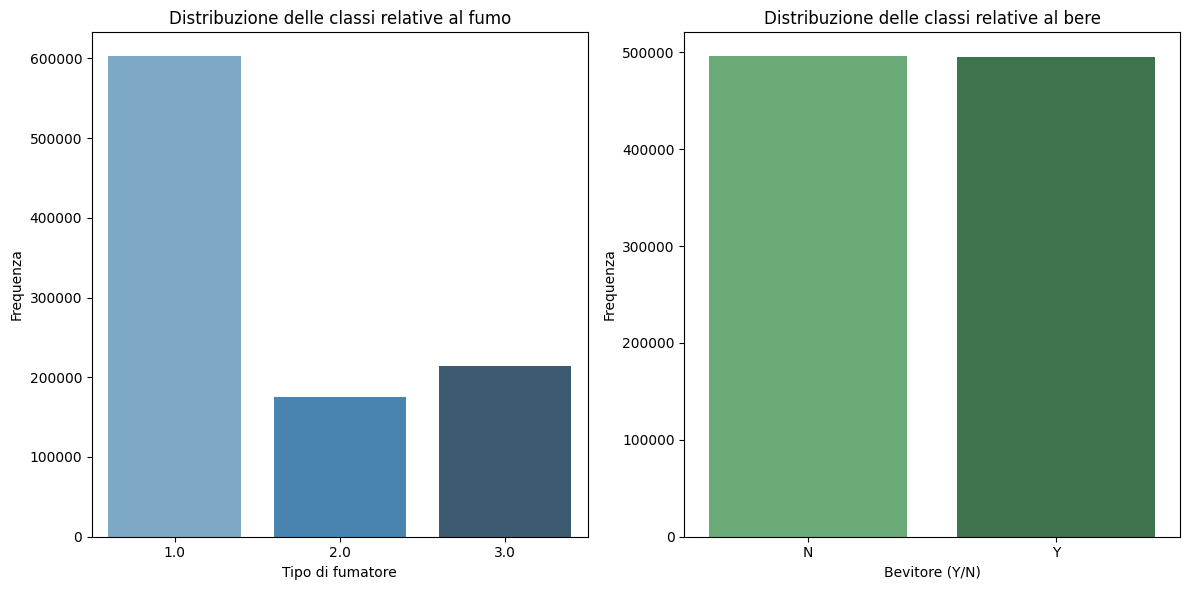

In [3]:
smoke = dataset["SMK_stat_type_cd"].value_counts()
drink = dataset["DRK_YN"].value_counts()

# Distribuzione SMK_stat_type_cd
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Num righe, num colonne, posizione 
sns.barplot(x=smoke.index, y=smoke.values, palette="Blues_d")
plt.title("Distribuzione delle classi relative al fumo")
plt.xlabel("Tipo di fumatore")
plt.ylabel("Frequenza")

# Distribuzione DRK_YN
plt.subplot(1, 2, 2)
sns.barplot(x=drink.index, y=drink.values, palette="Greens_d")
plt.title("Distribuzione delle classi relative al bere")
plt.xlabel("Bevitore (Y/N)")
plt.ylabel("Frequenza")

plt.tight_layout()
plt.show()

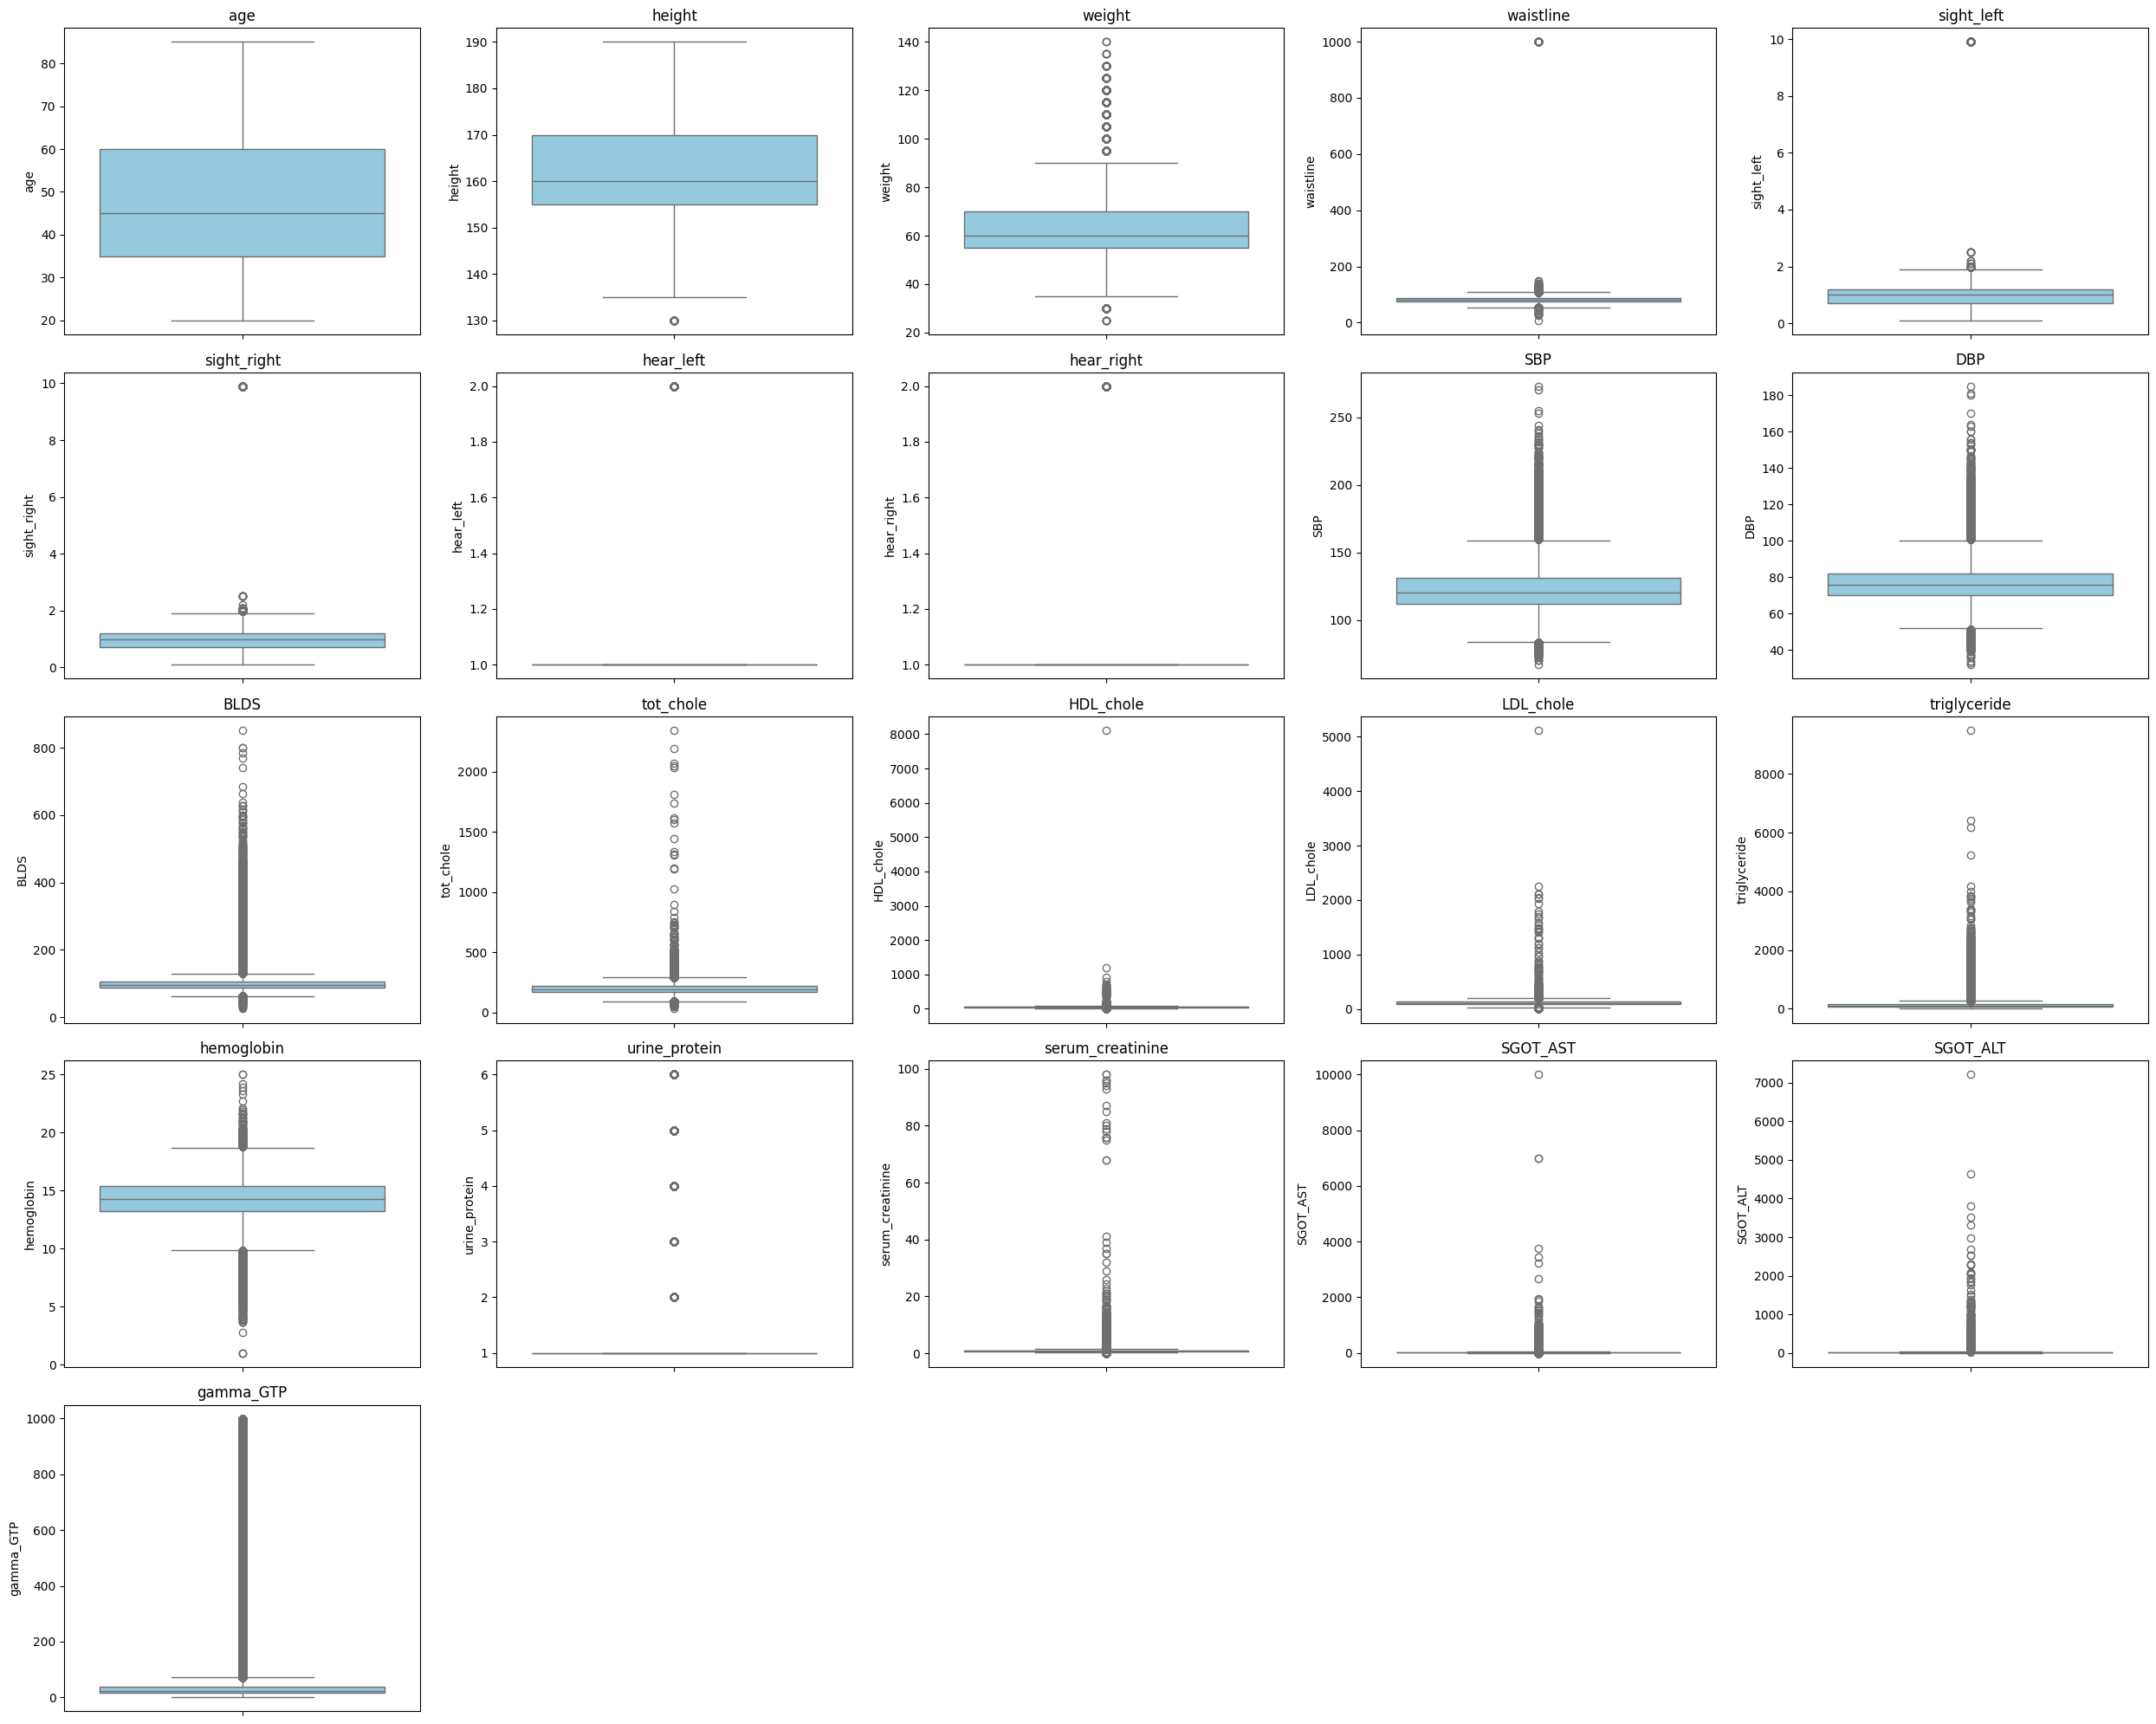

In [5]:
dataset_mod = dataset.drop(columns=["sex", "SMK_stat_type_cd", "DRK_YN"])

# Boxplot per le principali feature numeriche
plt.figure(figsize=(25, 20))
for i, col in enumerate(dataset_mod.columns):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=dataset_mod[col], color="skyblue")
    plt.title(col)
    plt.tight_layout()
plt.show()

In [6]:
# Verifica dei valori massimi e distanza dal secondo massimo e dalla media

for col in dataset_mod.columns:
    max = dataset_mod[col].max()
    max_count = (dataset_mod[col] == max).sum()
    second_max = dataset_mod[col][dataset_mod[col] < max].max()
    distance_max = max - second_max
    mean_value = dataset[col].mean()
    distance_mean = max - mean_value

    print(f"Colonna: {col}")
    print(f"    -Valore massimo: {max}")
    print(f"    -Occorrenze del massimo: {max_count}")
    print(f"    -Secondo massimo: {second_max}")
    print(f"    -Distanza tra massimo e secondo massimo: {distance_max}")
    print(f"    -Media: {mean_value}")
    print(f"    -Distanza tra massimo e media: {distance_mean}")
    print()

Colonna: age
    -Valore massimo: 85
    -Occorrenze del massimo: 3291
    -Secondo massimo: 80
    -Distanza tra massimo e secondo massimo: 5
    -Media: 47.614490803412735
    -Distanza tra massimo e media: 37.385509196587265

Colonna: height
    -Valore massimo: 190
    -Occorrenze del massimo: 363
    -Secondo massimo: 185
    -Distanza tra massimo e secondo massimo: 5
    -Media: 162.24062537196903
    -Distanza tra massimo e media: 27.75937462803097

Colonna: weight
    -Valore massimo: 140
    -Occorrenze del massimo: 3
    -Secondo massimo: 135
    -Distanza tra massimo e secondo massimo: 5
    -Media: 63.28405017017268
    -Distanza tra massimo e media: 76.71594982982732

Colonna: waistline
    -Valore massimo: 999.0
    -Occorrenze del massimo: 57
    -Secondo massimo: 149.1
    -Distanza tra massimo e secondo massimo: 849.9
    -Media: 81.23335777821268
    -Distanza tra massimo e media: 917.7666422217874

Colonna: sight_left
    -Valore massimo: 9.9
    -Occorrenze del mass

In [7]:
# Determinazione del numero di valori "fuori scala" (outliers) per ogni feature

for col in dataset_mod.columns:
    Q1 = dataset_mod[col].quantile(0.25)
    Q3 = dataset_mod[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = dataset_mod[(dataset_mod[col] < lower_bound) or (dataset_mod[col] > upper_bound)]
    print(f"Colonna: {col}")
    print(f"    -Valori fuori scala: {len(outliers)}")
    print(f"    -Limiti: {lower_bound} - {upper_bound}")
    print()

Colonna: age
    -Valori fuori scala: 0
    -Limiti: -2.5 - 97.5

Colonna: height
    -Valori fuori scala: 86
    -Limiti: 132.5 - 192.5

Colonna: weight
    -Valori fuori scala: 19221
    -Limiti: 32.5 - 92.5

Colonna: waistline
    -Valori fuori scala: 4417
    -Limiti: 53.54999999999999 - 108.35

Colonna: sight_left
    -Valori fuori scala: 11582
    -Limiti: -0.050000000000000044 - 1.95

Colonna: sight_right
    -Valori fuori scala: 10495
    -Limiti: -0.050000000000000044 - 1.95

Colonna: hear_left
    -Valori fuori scala: 31222
    -Limiti: 1.0 - 1.0

Colonna: hear_right
    -Valori fuori scala: 30212
    -Limiti: 1.0 - 1.0

Colonna: SBP
    -Valori fuori scala: 15836
    -Limiti: 83.5 - 159.5

Colonna: DBP
    -Valori fuori scala: 13122
    -Limiti: 52.0 - 100.0

Colonna: BLDS
    -Valori fuori scala: 64202
    -Limiti: 62.5 - 130.5

Colonna: tot_chole
    -Valori fuori scala: 11298
    -Limiti: 94.0 - 294.0

Colonna: HDL_chole
    -Valori fuori scala: 13858
    -Limiti: 16.0 - 

### Considerazioni

Un'analisi più approfondita ha permesso di individuare la presenza di alcuni outlier in specifiche feature, in particolare confrontando il valore massimo presente nel dataset con il secondo valore massimo per ciascuna di esse; è importante sottolineare però che non tutte le feature mostrano grosse differenze tra il primo e il secondo massimo ed in molti casi sono presenti molti valori tra il massimo e la media.

Sono state fatte dunque delle brevi ricerche per capire quali valori fossero plausibili per ogni feature e quali no, è stato deciso di stabilire una soglia massima accettabile per alcune di queste; queste soglie sono state definite con l'obiettivo di preservare il maggior numero possibile di righe del dataset originario ma eliminando allo stesso tempo i casi clinicamente estremi e rari, in modo da ottenere un dataset più generico, privo di situazioni patologiche estreme.

In [3]:
thresholds = {
    "waistline": 200,
    "sight_left": 4,
    "sight_right": 4,
    "SBP": 240,
    "DBP": 160,
    "BLDS": 600,
    "tot_chole": 1000,
    "HDL_chole": 700,
    "LDL_chole": 2000,
    "triglyceride": 3500,
    "serum_creatinine": 30,
    "SGOT_AST": 2000,
    "SGOT_ALT": 2000,
    "gamma_GTP": 900,
}

for col, threshold in thresholds.items():
    dataset.loc[dataset[col] > threshold, col] = None

# Rimozione delle righe con valori mancanti
dataset_cleaned = dataset.dropna(subset=thresholds.keys())

Ora verranno rieseguite tutte le operazioni di visualizzazione dei dati presenti nel dataset per comprendere la distribuzione di questi dopo l'operazione di rimozione degli outliers.

In [9]:
# Analisi iniziale del dataset
print("\nPrime righe del dataset:")
print(dataset_cleaned.head())

print("\nDimensioni del dataset:")
print(dataset_cleaned.shape)

print("\nTipi di dati:")
print(dataset_cleaned.info())

print("\nStatistiche descrittive di base:")
print(dataset_cleaned.describe())


Prime righe del dataset:
    sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0  Male   35     170      75       90.0         1.0          1.0        1.0   
1  Male   30     180      80       89.0         0.9          1.2        1.0   
2  Male   40     165      75       91.0         1.2          1.5        1.0   
3  Male   50     175      80       91.0         1.5          1.2        1.0   
4  Male   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1.0  138.0  ...      117.0         104.0        13.8            1.0   

   serum_cre

/var/folders/9k/0zc4z1md49d58jhbq4fgqjg40000gn/T/ipykernel_1061/3938718437.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=smoke.index, y=smoke.values, palette="Blues_d")
/var/folders/9k/0zc4z1md49d58jhbq4fgqjg40000gn/T/ipykernel_1061/3938718437.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=drink.index, y=drink.values, palette="Greens_d")


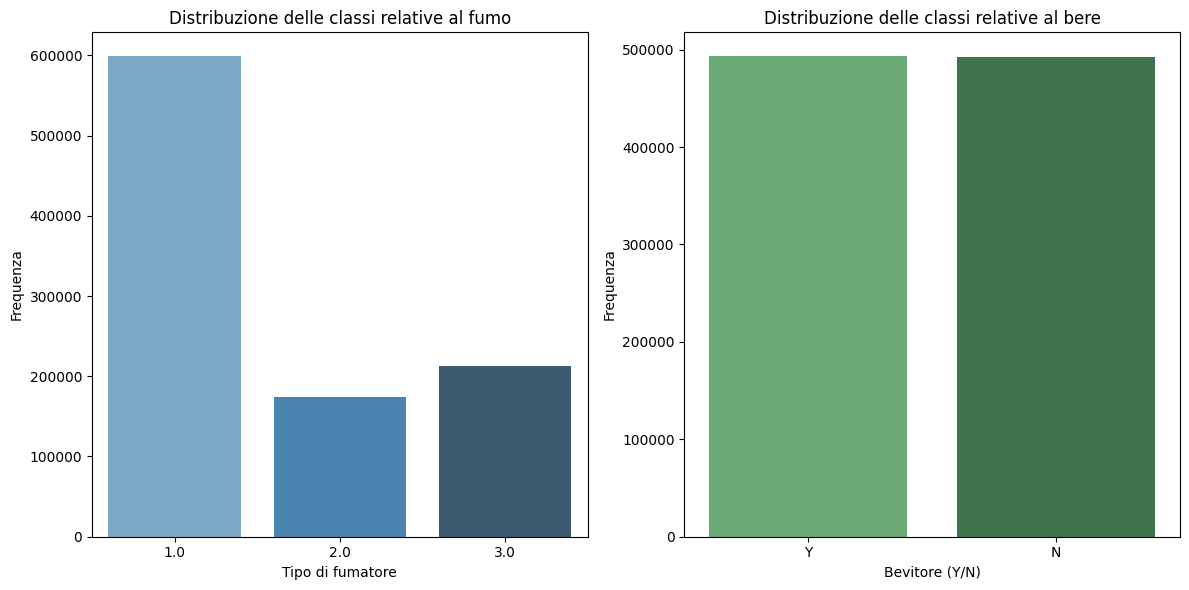

In [5]:
smoke = dataset_cleaned["SMK_stat_type_cd"].value_counts()
drink = dataset_cleaned["DRK_YN"].value_counts()

# Distribuzione SMK_stat_type_cd
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # Num righe, num colonne, posizione 
sns.barplot(x=smoke.index, y=smoke.values, palette="Blues_d")
plt.title("Distribuzione delle classi relative al fumo")
plt.xlabel("Tipo di fumatore")
plt.ylabel("Frequenza")

# Distribuzione DRK_YN
plt.subplot(1, 2, 2)
sns.barplot(x=drink.index, y=drink.values, palette="Greens_d")
plt.title("Distribuzione delle classi relative al bere")
plt.xlabel("Bevitore (Y/N)")
plt.ylabel("Frequenza")

plt.tight_layout()
plt.show()

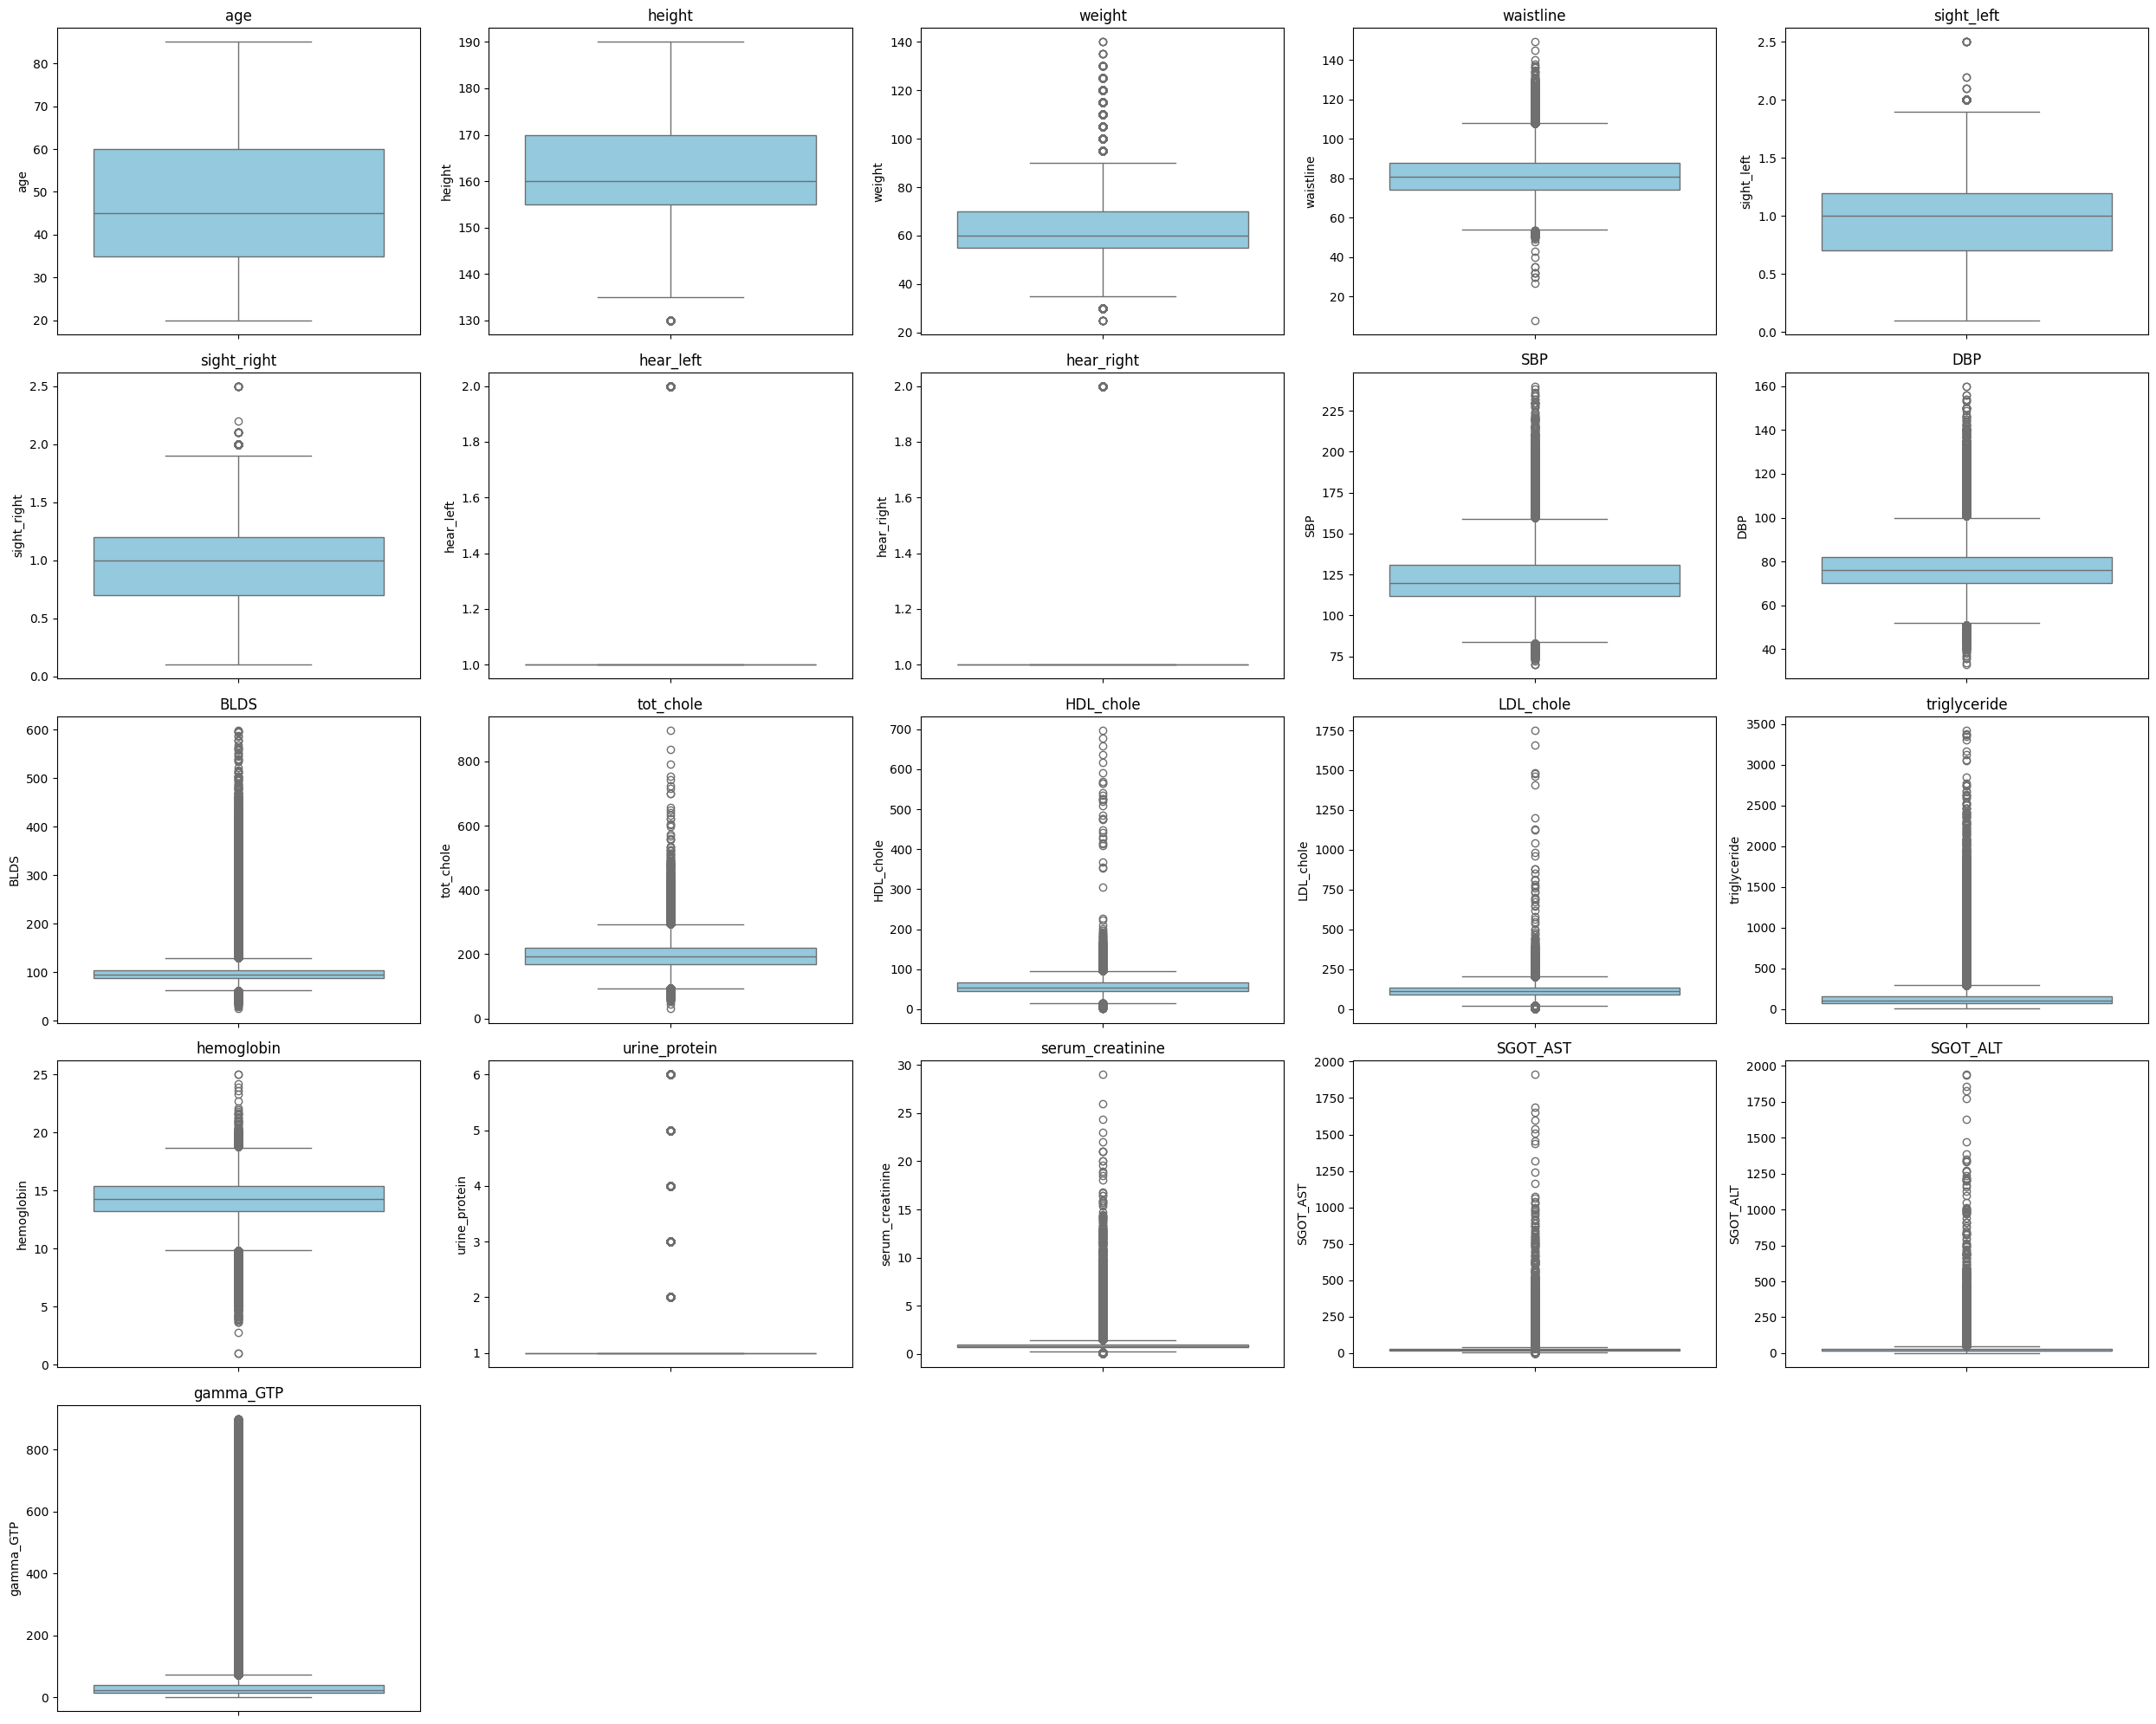

In [11]:
dataset_mod = dataset_cleaned.drop(columns=["sex", "SMK_stat_type_cd", "DRK_YN"])

# Boxplot per le principali feature numeriche
plt.figure(figsize=(25, 20))
for i, col in enumerate(dataset_mod.columns):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=dataset_mod[col], color="skyblue")
    plt.title(col)
    plt.tight_layout()
plt.show()

In [12]:
# Verifica dei valori massimi e distanza dal secondo massimo e dalla media

for col in dataset_mod.columns:
    max = dataset_mod[col].max()
    max_count = (dataset_mod[col] == max).sum()
    second_max = dataset_mod[col][dataset_mod[col] < max].max()
    distance_max = max - second_max
    mean_value = dataset[col].mean()
    distance_mean = max - mean_value

    print(f"Colonna: {col}")
    print(f"    -Valore massimo: {max}")
    print(f"    -Occorrenze del massimo: {max_count}")
    print(f"    -Secondo massimo: {second_max}")
    print(f"    -Distanza tra massimo e secondo massimo: {distance_max}")
    print(f"    -Media: {mean_value}")
    print(f"    -Distanza tra massimo e media: {distance_mean}")
    print()

Colonna: age
    -Valore massimo: 85
    -Occorrenze del massimo: 3114
    -Secondo massimo: 80
    -Distanza tra massimo e secondo massimo: 5
    -Media: 47.614490803412735
    -Distanza tra massimo e media: 37.385509196587265

Colonna: height
    -Valore massimo: 190
    -Occorrenze del massimo: 363
    -Secondo massimo: 185
    -Distanza tra massimo e secondo massimo: 5
    -Media: 162.24062537196903
    -Distanza tra massimo e media: 27.75937462803097

Colonna: weight
    -Valore massimo: 140
    -Occorrenze del massimo: 3
    -Secondo massimo: 135
    -Distanza tra massimo e secondo massimo: 5
    -Media: 63.28405017017268
    -Distanza tra massimo e media: 76.71594982982732

Colonna: waistline
    -Valore massimo: 149.1
    -Occorrenze del massimo: 1
    -Secondo massimo: 145.0
    -Distanza tra massimo e secondo massimo: 4.099999999999994
    -Media: 81.18058537923858
    -Distanza tra massimo e media: 67.91941462076142

Colonna: sight_left
    -Valore massimo: 2.5
    -Occorren

In [13]:
# Determinazione del numero di valori "fuori scala" (outliers) per ogni feature

for col in dataset_mod.columns:
    Q1 = dataset_mod[col].quantile(0.25)
    Q3 = dataset_mod[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = dataset_mod[(dataset_mod[col] < lower_bound) or (dataset_mod[col] > upper_bound)]
    print(f"Colonna: {col}")
    print(f"    -Valori fuori scala: {len(outliers)}")
    print(f"    -Limiti: {lower_bound} - {upper_bound}")
    print()

Colonna: age
    -Valori fuori scala: 0
    -Limiti: -2.5 - 97.5

Colonna: height
    -Valori fuori scala: 84
    -Limiti: 132.5 - 192.5

Colonna: weight
    -Valori fuori scala: 19149
    -Limiti: 32.5 - 92.5

Colonna: waistline
    -Valori fuori scala: 5274
    -Limiti: 53.60000000000001 - 107.99999999999999

Colonna: sight_left
    -Valori fuori scala: 8452
    -Limiti: -0.050000000000000044 - 1.95

Colonna: sight_right
    -Valori fuori scala: 7367
    -Limiti: -0.050000000000000044 - 1.95

Colonna: hear_left
    -Valori fuori scala: 30599
    -Limiti: 1.0 - 1.0

Colonna: hear_right
    -Valori fuori scala: 29620
    -Limiti: 1.0 - 1.0

Colonna: SBP
    -Valori fuori scala: 15565
    -Limiti: 83.5 - 159.5

Colonna: DBP
    -Valori fuori scala: 12993
    -Limiti: 52.0 - 100.0

Colonna: BLDS
    -Valori fuori scala: 63301
    -Limiti: 62.5 - 130.5

Colonna: tot_chole
    -Valori fuori scala: 11159
    -Limiti: 94.0 - 294.0

Colonna: HDL_chole
    -Valori fuori scala: 13723
    -Limit

Una volta terminata la fase di analisi e pulizia dei dati, sarebbe opportuno procedere con le operazioni di encoding e scaling dei dati (visto che sono presenti features con valori molto grandi e altre con valori più piccoli), però pensiamo sia più opportuno fare queste operazioni eventualmente in un secondo momento a seconda dei modelli di ML che decidiamo di utilizzare.
Per ora ci limitiamo a fare l'encoding delle feature categoriali.

In [4]:
categorical_cols = ["sex", "DRK_YN"]

for col in categorical_cols:
    encoder = LabelEncoder()
    dataset_cleaned[col] = encoder.fit_transform(dataset_cleaned[col])

print(dataset_cleaned.head())

   sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0    1   35     170      75       90.0         1.0          1.0        1.0   
1    1   30     180      80       89.0         0.9          1.2        1.0   
2    1   40     165      75       91.0         1.2          1.5        1.0   
3    1   50     175      80       91.0         1.5          1.2        1.0   
4    1   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1.0  138.0  ...      117.0         104.0        13.8            1.0   

   serum_creatinine  SGOT_AST  SGOT_ALT  gam

/var/folders/9k/0zc4z1md49d58jhbq4fgqjg40000gn/T/ipykernel_1921/3061775974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned[col] = encoder.fit_transform(dataset_cleaned[col])
/var/folders/9k/0zc4z1md49d58jhbq4fgqjg40000gn/T/ipykernel_1921/3061775974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned[col] = encoder.fit_transform(dataset_cleaned[col])


### Un primo esempio

Di seguito riportiamo un semplice modello di albero decisionale (o classificatore naive di Bayes?) per vedere che lower bound abbiamo per quanto riguarda le metriche di valutazione (accuratezza, recall, precisione, f1_score).

In [5]:
# Divisione del dataset in feature e target (X e Y)
target_smoke = "SMK_stat_type_cd"
target_drink = "DRK_YN"
#X_smoke = dataset_cleaned.iloc[:, dataset_cleaned.columns != target_smoke]
X_smoke = dataset_cleaned.drop(columns=["SMK_stat_type_cd", "DRK_YN"])
Y_smoke = dataset_cleaned[target_smoke]
#X_drink = dataset_cleaned.iloc[:, dataset_cleaned.columns != target_drink]
X_drink = dataset_cleaned.drop(columns=["SMK_stat_type_cd", "DRK_YN"])
Y_drink = dataset_cleaned[target_drink]

In [14]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, Y_smoke, test_size=0.3, random_state=42)
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_s, y_train_s)
y_pred = tree.predict(X_test_s)
accuracy = accuracy_score(y_test_s, y_pred) # balanced_accuracy_score(y_test_s, y_pred)
precision = precision_score(y_test_s, y_pred, average="weighted")
recall = recall_score(y_test_s, y_pred, average="weighted")
f1 = f1_score(y_test_s, y_pred, average="weighted")
print(f"Accuratezza: {accuracy*100:.2f}%")
print(f"Precisione: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1: {f1*100:.2f}%")

Accuratezza: 61.84%
Precisione: 62.14%
Recall: 61.84%
F1: 61.98%


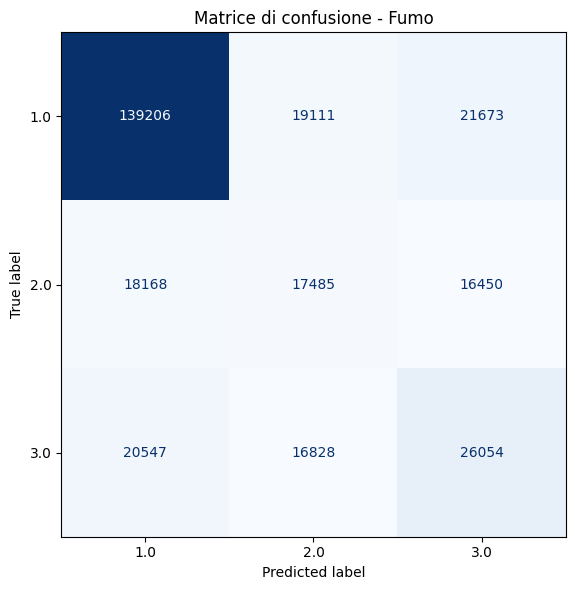

In [13]:
# Matrice di confusione per il fumo
confusion_matrix_smoking = confusion_matrix(y_test_s, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_smoking, display_labels=tree.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
display.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matrice di confusione - Fumo")
plt.tight_layout()
plt.show()

In [13]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drink, Y_drink, test_size=0.3, random_state=42)
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_d, y_train_d)
y_pred = tree.predict(X_test_d)
accuracy = accuracy_score(y_test_d, y_pred)
precision = precision_score(y_test_d, y_pred)
recall = recall_score(y_test_d, y_pred)
f1 = f1_score(y_test_d, y_pred)
print(f"Accuratezza: {accuracy*100:.2f}%")
print(f"Precisione: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1: {f1*100:.2f}%")

Accuratezza: 63.77%
Precisione: 63.74%
Recall: 63.75%
F1: 63.75%


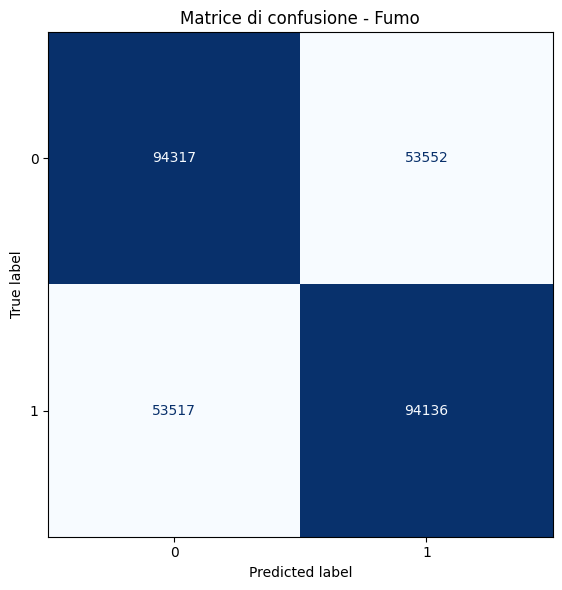

In [19]:
# Matrice di confusione per il bere
confusion_matrix_drinking = confusion_matrix(y_test_d, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_drinking, display_labels=tree.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
display.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matrice di confusione - Fumo")
plt.tight_layout()
plt.show()

__Prossimi passi__: da adesso in poi l'obiettivo sarà migliorare sempre di più le metriche delle predizioni sia per il caso del fumo che del bere, utilizzando modelli di apprendimento diversi e sfruttando tecniche di normalizzazione, feature selection, dimensionality reduction, encoding, etc. 

### RandomForest

In [20]:
# Iniziamo ad utilizzare dei modelli un po' più complessi e poco alla volta andiamo a migliorare il nostro modello con tecniche di preprocessing e tuning dei parametri
# Partiamo da una RandomForest (da adesso in poi le predizioni e le metriche, verranno salvate in nomi di variabili che contengono il nome del modello e la lettera 's' per smoke e 'd' per drink)

forest = RandomForestClassifier(random_state=42, class_weight="balanced")
forest.fit(X_train_s, y_train_s)
y_pred_rf_s = forest.predict(X_test_s)
accuracy_rf_s = accuracy_score(y_test_s, y_pred_rf_s) # balanced_accuracy_score(y_test_s, y_pred)
precision_rf_s = precision_score(y_test_s, y_pred_rf_s, average="weighted")
recall_rf_s = recall_score(y_test_s, y_pred_rf_s, average="weighted")
f1_rf_s = f1_score(y_test_s, y_pred_rf_s, average="weighted")
print(f"Accuratezza: {accuracy_rf_s*100:.2f}%")
print(f"Precisione: {precision_rf_s*100:.2f}%")
print(f"Recall: {recall_rf_s*100:.2f}%")
print(f"F1: {f1_rf_s*100:.2f}%")

Accuratezza: 69.26%
Precisione: 68.68%
Recall: 69.26%
F1: 68.83%


In [21]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_d, y_train_d)
y_pred_rf_d = forest.predict(X_test_d)
accuracy_rf_d = accuracy_score(y_test_d, y_pred_rf_d)
precision_rf_d = precision_score(y_test_d, y_pred_rf_d)
recall_rf_d = recall_score(y_test_d, y_pred_rf_d)
f1_rf_d = f1_score(y_test_d, y_pred_rf_d)
print(f"Accuratezza: {accuracy_rf_d*100:.2f}%")
print(f"Precisione: {precision_rf_d*100:.2f}%")
print(f"Recall: {recall_rf_d*100:.2f}%")
print(f"F1: {f1_rf_d*100:.2f}%")

Accuratezza: 72.68%
Precisione: 72.38%
Recall: 73.28%
F1: 72.83%


In [22]:
# Procediamo con il selezionare un paio di parametri e combinarli tra loro per vedere quale modello ottiene i risultati migliori

parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20],
    "min_samples_split": [50, 100, 200]
}

In [ ]:
for n_estimators in parameters["n_estimators"]:
    for max_depth in parameters["max_depth"]:
        for min_samples_split in parameters["min_samples_split"]:
            forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42, class_weight="balanced")
            forest.fit(X_train_s, y_train_s)
            y_pred_rf_s = forest.predict(X_test_s)
            accuracy_rf_s = accuracy_score(y_test_s, y_pred_rf_s) # balanced_accuracy_score(y_test_s, y_pred)
            precision_rf_s = precision_score(y_test_s, y_pred_rf_s, average="weighted")
            recall_rf_s = recall_score(y_test_s, y_pred_rf_s, average="weighted")
            f1_rf_s = f1_score(y_test_s, y_pred_rf_s, average="weighted")
            print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}")
            print(f"    Accuratezza: {accuracy_rf_s*100:.2f}%")
            print(f"    Precisione: {precision_rf_s*100:.2f}%")
            print(f"    Recall: {recall_rf_s*100:.2f}%")
            print(f"    F1: {f1_rf_s*100:.2f}%")

La miglior scelta dei parametri risulta essere la seguente:
- **n_estimators**: 100
- **max_depth**: 20
- **min_samples_split**: 50

In [39]:
forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42, class_weight="balanced")
forest.fit(X_train_s, y_train_s)
y_pred_rf_s = forest.predict(X_test_s)
accuracy_rf_s = accuracy_score(y_test_s, y_pred_rf_s) # balanced_accuracy_score(y_test_s, y_pred)
precision_rf_s = precision_score(y_test_s, y_pred_rf_s, average="weighted")
recall_rf_s = recall_score(y_test_s, y_pred_rf_s, average="weighted")
f1_rf_s = f1_score(y_test_s, y_pred_rf_s, average="weighted")
print(f"Accuratezza: {accuracy_rf_s*100:.2f}%")
print(f"Precisione: {precision_rf_s*100:.2f}%")
print(f"Recall: {recall_rf_s*100:.2f}%")
print(f"F1: {f1_rf_s*100:.2f}%")

Accuratezza: 68.25%
Precisione: 75.07%
Recall: 68.25%
F1: 70.35%


In [ ]:
for n_estimators in parameters["n_estimators"]:
    for max_depth in parameters["max_depth"]:
        for min_samples_split in parameters["min_samples_split"]:
            forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
            forest.fit(X_train_d, y_train_d)
            y_pred_rf_d = forest.predict(X_test_d)
            accuracy_rf_d = accuracy_score(y_test_d, y_pred_rf_d)
            precision_rf_d = precision_score(y_test_d, y_pred_rf_d)
            recall_rf_d = recall_score(y_test_d, y_pred_rf_d)
            f1_rf_d = f1_score(y_test_d, y_pred_rf_d)
            print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}")
            print(f"    Accuratezza: {accuracy_rf_d*100:.2f}%")
            print(f"    Precisione: {precision_rf_d*100:.2f}%")
            print(f"    Recall: {recall_rf_d*100:.2f}%")
            print(f"    F1: {f1_rf_d*100:.2f}%")

La miglior scelta dei parametri risulta essere la seguente:
- **n_estimators**: 100
- **max_depth**: 20
- **min_samples_split**: 50

In [14]:
forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42)
forest.fit(X_train_d, y_train_d)
y_pred_rf_d = forest.predict(X_test_d)
accuracy_rf_d = accuracy_score(y_test_d, y_pred_rf_d)
precision_rf_d = precision_score(y_test_d, y_pred_rf_d)
recall_rf_d = recall_score(y_test_d, y_pred_rf_d)
f1_rf_d = f1_score(y_test_d, y_pred_rf_d)
print(f"Accuratezza: {accuracy_rf_d*100:.2f}%")
print(f"Precisione: {precision_rf_d*100:.2f}%")
print(f"Recall: {recall_rf_d*100:.2f}%")
print(f"F1: {f1_rf_d*100:.2f}%")

Accuratezza: 72.92%
Precisione: 72.07%
Recall: 74.77%
F1: 73.39%


Ora che sono stati definiti i parametri migliori per le random forest, procediamo con la tecnica della feature selection con la speranza di migliorare i risultati di accuratezza, precisione, recall e f1_score; pensiamo sia un'operazione da compiere per poter ottenere risultati migliori, perchè abbiamo a che fare con un dataset con 22 feature che non sono poche e il rischio di overfit c'è. Probabilmente con una random forest questo rischio è minore, però testiamo se anche con una random forest i risultati migliorano.

### RandomForest con feature selection

In questa fase del progetto, proviamo ad ottimizzare la RandomForest facendo feature selection; avendo a che fare con un modello predittivo di questo tipo, ovvero abbastanza robusto alle feature irrilevanti, non ci aspettiamo un grosso miglioramento delle performance ma nonostante ciò è comunque un passaggio utile per poter eventualmente semplificare il modello andando a togliere anche poche feature e rendere il modello predittivo poco più veloce.
Inoltre nella prossima cella di codice, non viene indicato a priori un numero fissato di feature da selezionare, in quanto non certi di quelle che possano essere le performance selezionando solo il 10%, il 20%, il 50%, il 75%... delle feature; quindi calcoliamo la f1_score (che per il caso multiclasse ci sembra essere la metrica migliore) ad ogni best_feature aggiunta e salviamo la combinazione di feature migliore tra tutte quelle testate.

In [ ]:
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_smoke, Y_smoke, test_size=0.3, random_state=42)

selected_features_s = []
best_selected_features_s = []
remaining_features = [col for col in X_train_s.columns] 
best_overall_score = 0

while len(remaining_features) > 0:
    best_score = 0
    best_feature = None
    
    for feature in remaining_features:
        current_features = selected_features_s + [feature]
        forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42, class_weight="balanced")
        forest.fit(X_train_s.loc[:, current_features], y_train_s)
        y_pred = forest.predict(X_val_s.loc[:, current_features])
        score = f1_score(y_val_s, y_pred, average="weighted")
        
        if score > best_score:
            best_score = score
            best_feature = feature

    selected_features_s.append(best_feature)
    remaining_features.remove(best_feature)
    print(f"Feature selezionata: {best_feature}, score: {best_score*100:.2f}%")

    if best_score > best_overall_score:
        best_overall_score = score
        best_selected_features_s = selected_features_s.copy()
            
print("Feature finali selezionate:", best_selected_features_s)

**NB:** i risultati della cella precedente sono stati copiati e riportati in questa cella di markdown perchè i tempi per ottenere i risultati erano molto lunghi e sono stati ottenuti in momenti diversi.

Feature selezionata: height, score: 61.46%  
Feature selezionata: sex, score: 66.84%  
Feature selezionata: age, score: 69.13%  
Feature selezionata: weight, score: 69.33%  
Feature selezionata: gamma_GTP, score: 69.35%  
Feature selezionata: HDL_chole, score: 69.77%  
Feature selezionata: SGOT_ALT, score: 70.01%  
Feature selezionata: hemoglobin, score: 70.16%  
Feature selezionata: SGOT_AST, score: 70.24%  
Feature selezionata: DBP, score: 70.30%  
Feature selezionata: LDL_chole, score: 70.32%  
Feature selezionata: serum_creatinine, score: 70.36%  
Feature selezionata: triglyceride, score: 70.40%  
Feature selezionata: BLDS, score: 70.42%  
Feature selezionata: sight_right, score: 70.41%  
Feature selezionata: hear_right, score: 70.43%  
Feature selezionata: urine_protein, score: 70.42%  
Feature selezionata: SBP, score: 70.40%  
Feature selezionata: waistline, score: 70.39%  
Feature selezionata: hear_left, score: 70.42%  
Feature selezionata: tot_chole, score: 70.38%  
Feature selezionata: urine_protein, score: 70.37%  
Feature selezionata: sight_left, score: 70.40%  
Feature selezionata: SBP, score: 70.35%  
Feature finali selezionate: ['age', 'sex', 'height', 'weight', 'hear_right', 'sight_right', 'DBP', 'BLDS', 'HDL_chole', 'LDL_chole', 'triglyceride', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'hemoglobin']

In [ ]:
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_drink, Y_drink, test_size=0.3, random_state=42)

selected_features_d = []
best_selected_features_d = []
remaining_features = [col for col in X_train_d.columns] 
best_overall_score = 0

while len(remaining_features) > 0:
    best_score = 0
    best_feature = None
    
    for feature in remaining_features:
        current_features = selected_features_d + [feature]
        forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42)
        forest.fit(X_train_d.loc[:, current_features], y_train_d)
        y_pred = forest.predict(X_val_d.loc[:, current_features])
        score = accuracy_score(y_val_d, y_pred)
        
        if score > best_score:
            best_score = score
            best_feature = feature

    selected_features_d.append(best_feature)
    remaining_features.remove(best_feature)
    print(f"Feature selezionata: {best_feature}, score: {best_score*100:.2f}%")

    if best_score > best_overall_score:
        best_overall_score = score
        best_selected_features_d = selected_features_d.copy()
            
print("Feature finali selezionate:", best_selected_features_d)

**NB:** i risultati della cella precedente sono stati copiati e riportati in questa cella di markdown perchè i tempi per ottenere i risultati erano molto lunghi e sono stati ottenuti in momenti diversi.

Feature selezionata: sex, score: 68.30%  
Feature selezionata: age, score: 70.13%  
Feature selezionata: gamma_GTP, score: 71.26%   
Feature selezionata: HDL_chole, score: 71.61%  
Feature selezionata: SGOT_ALT, score: 72.25%  
Feature selezionata: weight, score: 72.53%  
Feature selezionata: SGOT_AST, score: 72.74%  
Feature selezionata: tot_chole, score: 72.90%  
Feature selezionata: triglyceride, score: 72.94%  
Feature selezionata: LDL_chole, score: 73.01%  
Feature selezionata: serum_creatinine, score: 72.99%  
Feature selezionata: DBP, score: 73.06%  
Feature selezionata: hemoglobin, score: 73.05%  
Feature selezionata: BLDS, score: 73.04%  
Feature selezionata: hear_right, score: 72.99%  
Feature selezionata: waistline, score: 73.06%  
Feature selezionata: hear_left, score: 73.03%  
Feature selezionata: height, score: 73.07%  
Feature selezionata: sight_left, score: 73.05%  
Feature selezionata: sight_right, score: 73.01%  
Feature selezionata: SBP, score: 72.97%  
Feature selezionata: urine_protein, score: 72.90%  
Feature finali selezionate: ['sex', 'age', 'gamma_GTP', 'HDL_chole', 'SGOT_ALT', 'weight', 'SGOT_AST', 'tot_chole', 'triglyceride', 'LDL_chole', 'serum_creatinine', 'DBP', 'hemoglobin', 'BLDS', 'hear_right', 'waistline', 'hear_left', 'height']

In [11]:
best_selected_features_d = ["sex", "age", "gamma_GTP", "HDL_chole", "SGOT_ALT", "weight", "SGOT_AST", "tot_chole", "triglyceride", "LDL_chole", "serum_creatinine", "DBP", "hemoglobin", "BLDS", "hear_right", "waistline", "hear_left", "height"]
best_selected_features_s = ["age", "sex", "height", "weight", "hear_right", "sight_right", "DBP", "BLDS", "HDL_chole", "LDL_chole", "triglyceride", "serum_creatinine", "SGOT_AST", "SGOT_ALT", "gamma_GTP", "hemoglobin"]

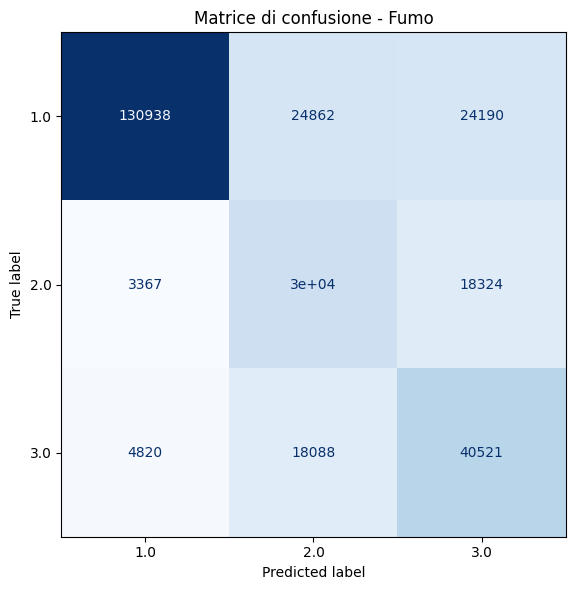

In [15]:
# Matrice di confusione per il fumo e con le feature selezionate
forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42, class_weight="balanced")
forest.fit(X_train_s.loc[:, best_selected_features_s], y_train_s)
y_pred_rf_s = forest.predict(X_test_s.loc[:, best_selected_features_s])
confusion_matrix_s = confusion_matrix(y_test_s, y_pred_rf_s)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_s, display_labels=forest.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
display.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matrice di confusione - Fumo")
plt.tight_layout()
plt.show()

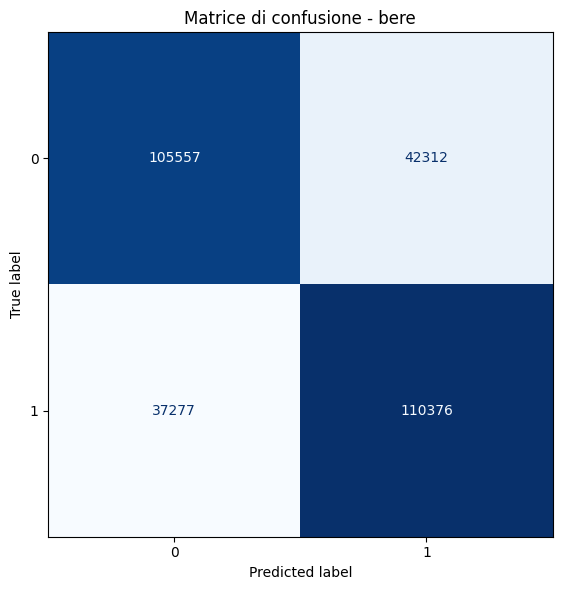

In [16]:
# Matrice di confusione per il bere e con le feature selezionate
forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42)
forest.fit(X_train_d.loc[:, best_selected_features_d], y_train_d)
y_pred_rf_d = forest.predict(X_test_d.loc[:, best_selected_features_d])
confusion_matrix_d = confusion_matrix(y_test_d, y_pred_rf_d)
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_d, display_labels=forest.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
display.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matrice di confusione - bere")
plt.tight_layout()
plt.show()

### Random forest con feature reduction e cross validation

In questa ultima parte relativa l'utilizzo della RandomForest come modello di appredimento, useremo la cross validation per valutare in maniera più precisa le performance dopo aver fatto feature selection.
Siccome nello step precedente abbiamo allenato il nostro modello tenendo però costante il set di train e di validazione, potremmo aver "overfittato" in base alla suddivisione specifica; con la cross-validation, testiamo il modello su diverse porzioni del dataset e possiamo valutare se le feature scelte migliorano davvero il modello.


In [20]:
forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42, class_weight="balanced")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_score_rf_s = cross_val_score(forest, X_smoke.loc[:, best_selected_features_s], Y_smoke, cv=cv, scoring='f1_weighted', n_jobs=-1)
accuracy_rf_s = cross_val_score(forest, X_smoke.loc[:, best_selected_features_s], Y_smoke, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
print(f"F1-score medio: {f1_score_rf_s.mean()*100:.2f}%")
print(f"Accuratezza media: {accuracy_rf_s.mean()*100:.2f}%")

F1-score medio: 70.42%
Accuratezza media: 65.02%


In [22]:
forest = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_score_rf_d = cross_val_score(forest, X_drink.loc[:, best_selected_features_d], Y_drink, cv=cv, scoring='f1', n_jobs=-1)
accuracy_rf_d = cross_val_score(forest, X_drink.loc[:, best_selected_features_d], Y_drink, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"F1-score medio: {f1_score_rf_d.mean()*100:.2f}%")
print(f"Accuratezza media: {accuracy_rf_d.mean()*100:.2f}%")

F1-score medio: 73.56%
Accuratezza media: 73.11%


Prossimi modelli da poter usare:
- KNN
- SVM
- AdaBoost

### Support Vector Machine

Da adesso in poi, invece, verrà utilizzato un modello di predizione diverso e di conseguenza verranno anche utilizzate tecniche di scaling e encoding per sfruttare al meglio le caratteristiche del modello stesso.  
Più nel dettaglio verrà fatto:
- __Scaling delle feature:__ SVM è sensibile alle diverse scale dei dati, quindi dobbiamo standardizzare le feature numeriche.

In [14]:
scaler = StandardScaler()
X_smoke_scaled = scaler.fit_transform(X_smoke)
X_drink_scaled = scaler.fit_transform(X_drink)
X_smoke_scaled = pd.DataFrame(X_smoke_scaled, columns=X_smoke.columns)
X_drink_scaled = pd.DataFrame(X_drink_scaled, columns=X_drink.columns)

In [15]:
# Siccome il train di un modello SVM è molto pesante, utilizziamo solo una parte delle feature
best_selected_features_d = ["sex", "age", "gamma_GTP", "HDL_chole", "SGOT_ALT", "weight", "SGOT_AST", "tot_chole", "triglyceride", "LDL_chole", "serum_creatinine", "DBP"]
best_selected_features_s = ["age", "sex", "height", "weight", "DBP", "BLDS", "HDL_chole", "LDL_chole", "triglyceride", "serum_creatinine", "SGOT_AST", "SGOT_ALT", "gamma_GTP", "hemoglobin"]

In [ ]:
# Prova con SVM con kernel lineare e train_set ridotto (34 minuti per ottenere i risultati)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke_scaled, Y_smoke, test_size=0.8, random_state=42)
svm = SVC(kernel="linear", class_weight="balanced", C=1)
svm.fit(X_train_s.loc[:, best_selected_features_s], y_train_s)
y_pred = svm.predict(X_test_s.loc[:,best_selected_features_s])
accuracy_svm_s = accuracy_score(y_test_s, y_pred) # balanced_accuracy_score(y_test_s, y_pred)
precision_svm_s = precision_score(y_test_s, y_pred, average="weighted")
recall_svm_s = recall_score(y_test_s, y_pred, average="weighted")
f1_svm_s = f1_score(y_test_s, y_pred, average="weighted")
print(f"Accuratezza: {accuracy_svm_s*100:.2f}%")
print(f"Precisione: {precision_svm_s*100:.2f}%")
print(f"Recall: {recall_svm_s*100:.2f}%")
print(f"F1: {f1_svm_s*100:.2f}%")

Accuratezza: 67.67%
Precisione: 74.66%
Recall: 67.67%
F1: 69.86%


In [ ]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drink_scaled, Y_drink, test_size=0.3, random_state=42)
svm = SVC(kernel="linear", C=1)
svm.fit(X_train_d, y_train_d)
y_pred = svm.predict(X_test_d)
accuracy_svm_d = accuracy_score(y_test_d, y_pred)
precision_svm_d = precision_score(y_test_d, y_pred)
recall_svm_d = recall_score(y_test_d, y_pred)
f1_svm_d = f1_score(y_test_d, y_pred)
print(f"Accuratezza: {accuracy_svm_d*100:.2f}%")
print(f"Precisione: {precision_svm_d*100:.2f}%")
print(f"Recall: {recall_svm_d*100:.2f}%")
print(f"F1: {f1_svm_d*100:.2f}%")